# Analysis of IMDB data using the ArangoDB Netoworkx adapter 

This notebook will illustrate how the Networkx adapter can be used to perform graph analytics tasks on graph data stored in ArangoDB. For this example we will use the IMDB movie review dataset. The dataset provides reviews of various movies by viewers. The details of the dataset are available [here](https://www.imdb.com/interfaces/). If we use a relational representation to analyze this problem, then we will need to know what we want to look in the data and then seek it from the data. For example we may be interested in the average rating for a particular genre of movies. The point here is that we need to know the questions that are important in the analysis of this problem apriori. When we use a graph representation of this data, then we can leverage the body of ideas used in network analysis (or social network analysis) to extract insights from the data. The body of ideas are the standard questions we seek answers to when analyzing any network. The answers to these questions will provide us insights about the data and the problem. In other words, we have a framework for extracting insights from the data. In the example provided in this notebook, we will use ideas from the analysis of bipartite graphs to illustrate this point. Of course, if we have a specific question that we are seeking the answer for, then that is available easily from the graph as well. Therefore, going with a graph represenation makes it easier to extract insights from the data.t

The advantages of using a graph representation for the data extend beyond mining and learning from the data. Running adhoc queries for analytic purposes on the data is more efficient with a graph representation. With a relational representation, we can only optimize query performance for queries that are known before hand (with indexes). Adhoc queries could require multiple joins and have poor performance. Most graphs, have the so called _small world effect_. In such graphs, most nodes can be reached from most other nodes with a small number of edge traversals. An adhoc query starting at any node can reach the node of interest in a few hops.

The illustration in this notebook is organized as follows:
1. Loading the data for the example.
2. Creating the Networkx graph from the AranogoDB graph using the Networkx Adapter.
3. Analysis of the graph using Networkx.
4. Using the Networkx graph to obtain a graph embedding using _Node2vec_.
5. Using Arangopipe to store metadata about this experiment.

# Loading the Data into ArangoDB

We will use Oasis, ArangoDB's managed service offering, for this example. We will start with installing the required libraries to run this example. We will then connect to Oasis, obtain a connection and create the database.After creating the database, we will load the data into ArangoDB. The next few cells illustrate these steps.

## Install Required Libraries 

<a href="https://colab.research.google.com/github/arangoml/networkx-adapter/blob/narrative_addition/examples/IMDB_Networkx_Adapter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [93]:
%%capture
!mkdir oasis
!mkdir IMDBdata
!git clone -b imdb_with_ratings https://github.com/arangodb/interactive_tutorials IMDBdata
!git clone -b oasis_connector https://github.com/arangodb/interactive_tutorials oasis
!rsync -av oasis/ ./ --exclude=.git
!chmod -R 755 ./data
!chmod -R 755 ./tools
!chmod -R 755 ./oasis

!pip3 install networkx
!pip3 install matplotlib
!pip3 install --index-url https://test.pypi.org/simple/ adbnx-adapter==0.0.0.2.5.3
!pip3 install pyarango
!pip3 install python-arango
!pip install node2vec
!pip install seaborn
!pip install arangopipe==0.0.6.9.3

## Get a Oasis Connection

__Oasis__, the managed database service offering from ArangoDB, will be used for this exercise. This eliminates the need for setting up and configuring an instance of a database.

In [133]:
from adbnx_adapter.arangoDB_networkx_adapter import ArangoDB_Networkx_Adapter
import oasis
conn = oasis.getTempCredentials()

print("https://{}:{}".format(conn["hostname"], conn["port"]))
print("Username: " + conn["username"])
print("Password: " + conn["password"])
print("Database: " + conn["dbName"])

class IMDB_ArangoDB_Networkx_Adapter(ArangoDB_Networkx_Adapter):
    # We re-define how vertex insertion should be treated, specifically for the IMDB dataset.
    def insert_nx_vertex(self, vertex: dict, collection: str, attributes: set):
        bip_key = 0 if collection == "Users" else 1
        self.nx_graph.add_node(vertex["_id"], attr_dict=vertex, bipartite=bip_key)

ma = IMDB_ArangoDB_Networkx_Adapter(conn)

Reusing cached credentials.

https://d383fa0b596a.arangodb.cloud:8529
Username: TUTavlkt1fv7jsujf5ai5qjcl
Password: TUTn5bwjhjf4rg2rzkub9hnvu
Database: TUT276o8okjtpdqehucmszbfs


## Create the Collections for the Database 

In [134]:
# Connect to the temp database
conn = oasis.connect(con)
db = conn[con["dbName"]]

## Import the Data 

In [135]:
! ./tools/arangorestore -c none --server.endpoint http+ssl://{con["hostname"]}:{con["port"]} --server.username {con["username"]} --server.database {con["dbName"]} --server.password {con["password"]} --default-replication-factor 3  --input-directory "./IMDBdata/data/imdb_with_ratings"

2021-03-11T21:14:40Z [996] INFO [05c30] {restore} Connected to ArangoDB 'http+ssl://d383fa0b596a.arangodb.cloud:8529'
2021-03-11T21:14:41Z [996] INFO [abeb4] {restore} Database name in source dump is 'TUTdit9ohpgz1ntnbetsjstwi'
2021-03-11T21:14:41Z [996] INFO [9b414] {restore} # Re-creating document collection 'Movies'...
2021-03-11T21:14:42Z [996] INFO [9b414] {restore} # Re-creating document collection 'Users'...
2021-03-11T21:14:42Z [996] INFO [9b414] {restore} # Re-creating edge collection 'Ratings'...
2021-03-11T21:14:43Z [996] INFO [6d69f] {restore} # Dispatched 3 job(s), using 2 worker(s)
2021-03-11T21:14:43Z [996] INFO [94913] {restore} # Loading data into document collection 'Users', data size: 16717 byte(s)
2021-03-11T21:14:43Z [996] INFO [94913] {restore} # Loading data into document collection 'Movies', data size: 68107 byte(s)
2021-03-11T21:14:43Z [996] INFO [6ae09] {restore} # Successfully restored document collection 'Users'
2021-03-11T21:14:43Z [996] INFO [94913] {resto

In [137]:
import csv
import json
import requests
import sys
import oasis
from pyArango.connection import *
from pyArango.collection import Collection, Edges, Field
from pyArango.graph import Graph, EdgeDefinition

class Users(Collection):
    _fields = {
        "user_id": Field(),
        "age": Field(),
        "gender": Field()
    }
    
class Movies(Collection):
    _fields = {
        "movie_id": Field(),
        "movie_title": Field(),
        "release_data": Field()
    }

class Ratings(Edges): 
    _fields = {
        #user_id and movie_id (_key of movie) are encoded by _from, _to 
        "rating": Field(),
        "timestamp": Field()
    }

class IMDBGraph(Graph):
    _edgeDefinitions = [EdgeDefinition("Ratings", fromCollections=["Users"], toCollections=["Movies"])]
    _orphanedCollections = []

iMDBGraph = db.createGraph("IMDBGraph", replicationFactor=3)

print("Collection/Graph Setup done.")

Collection/Graph Setup done.


# Use the Networkx-Adapter to create a Networkx Graph

Now that we have loaded the data into ArangoDB, we can use the __Networkx-Adapter__ to create _Networkx_ graphs from the ArangoDB graph. To do so, we'll have to provide a graph descriptor that describes the graph structure to the __Networkx-Adapter__. These steps are illustrated below. 

## Specify the Graph Structure 

To use the IMDB Networkx Adapter, we need to specify the structure of the graph that we want to create. This is done with a simple dictionary. 

In [138]:
imdb_attributes = {'vertexCollections': {'Users': {},
                                         'Movies': {}},
                   'edgeCollections': {'Ratings': {'_from', '_to', 'ratings'}}}

## Obtain the networkx graph

In [139]:
g = ma.create_networkx_graph(
    graph_name='IMDBGraph',  graph_attributes=imdb_attributes)

__Done!__, we now have a _Networkx_ graph representation that we can use for analysis!

# Analysis of the IMDB reviews dataset with Networkx
We just created a networkx graph for this problem. In this notebook we will use a small set of ideas from the standard body of ideas used in network analysis to extract insights from the movie review dataset. Networkx provides an implementation of these ideas. These will be discussed next.

As mentioned earlier, one of the advantages of using a graph representation is that we can leverage the standard body of ideas used to analyze networks to extract information about this dataset. In what follows, we will call out such facts as we identify them.



## Get the user and movie nodes

In [140]:
user_nodes = [n for n in g.nodes() if n.startswith("Users")]
movie_nodes = [n for n in g.nodes() if n.startswith("Movies")]

## Structural Property Introspection: Number of Nodes and Edges

In [141]:
print("Number of Users are %d" % (len(user_nodes)))
print("Number of Movies are %d" % (len(movie_nodes)))
print("Number of Ratings are %d" % (len(list(g.edges()))))

Number of Users are 943
Number of Movies are 1682
Number of Ratings are 65499


## Convert the graph obtained from the interface to a bi-partite graph 

In [142]:
import networkx as nx
B = nx.Graph()
B.add_nodes_from(user_nodes, bipartite=0)
B.add_nodes_from(movie_nodes, bipartite=1)
B.add_edges_from(list(g.edges()))

### Identified fact:
_The graph has two kinds of edges. It has 943 users and and 1682 Movies. A user may watch multiple movies. 65499 movie ratings are available. This information is obtained by simply identifying the structure of the graph._

In [143]:
from networkx.algorithms import bipartite
bipartite.is_bipartite(B)

True

## Is the graph connected?
If the graph is connected then there is a path between any two nodes in the graph. If not, then some nodes are not connected. In the context of this application, a disconnected graph implies that there exist users in the graph who may not have rated a movie in common. If it is true that any given pair of users have rated at least one movie in common, then there is a path connecting these users through the movie they have rated in common.

## Identified fact:
_In the user community, if we pick any two users, then it is possible that they may not have rated a movie in common._

In [144]:
nx.is_connected(B)

False

In [145]:
users = [n for n in B.nodes if B.nodes[n]['bipartite'] == 0]
movies = [n for n in B.nodes if B.nodes[n]['bipartite'] == 1]

## How many movies does a User rate?
This is a distribution. A review of the plot below will show the familiar long tailed distribution. Most viewers rate less than say 100 movies. There are some serious reviewers out there though. These are on the tail of the distribution.

In [146]:
degu, degm = bipartite.degrees(B, movies)

In [147]:
du = [v for k,v in degu]

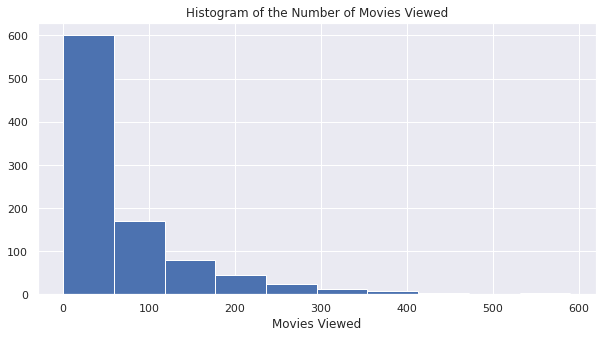

In [148]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
ax = plt.hist(du)
plt.title("Histogram of the Number of Movies Viewed")
plt.xlabel("Movies Viewed")
plt.grid(True)

### Identified fact:
_Inspecting the degree distribution of vertices is an activity we commonly perform to understand some basic characteristics of the network. In this application, this activity shows that most user's rate less than a 100 movies. The graph above is an example of "long tailed distribution". This is commonly seen in social networks._

## How many users rate a movie?
This is also a distribution that also has the long tailed behavior. Most mvoies are rated by less than 100 users. There are some movies that are rated by many viewers though.

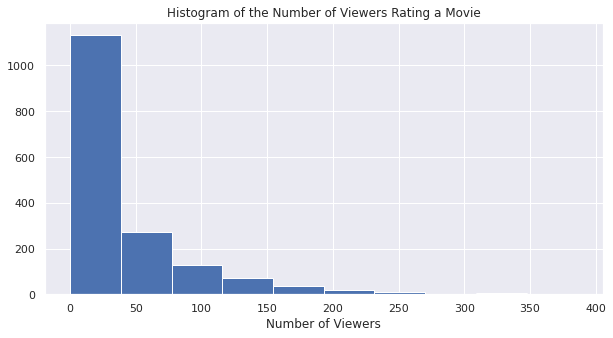

In [149]:
dm = [v for k,v in degm]
plt.rcParams['figure.figsize'] = [10, 5]
ax = plt.hist(dm)
plt.title("Histogram of the Number of Viewers Rating a Movie")
plt.xlabel("Number of Viewers")
plt.grid(True)

### Identified fact:
_We can repeat the exploration of degree distribution with the movie nodes. The behavior observed with the movie nodes is similar to what is observed with the user nodes. We observe the same "long tailed" distribution and most movies are rated by less than a 100 users._

## Centrality Measures

A centrality measure identifies influential nodes in a network. How do we formalize the observations about movie importance and the user's rating behavior in the given network? The notion of centrality measure is useful in this regard. Many measures of node centrality are used, see [Chapter 3 of the text book by Zafarani et.al](http://dmml.asu.edu/smm/) for details. We will use degree centraility in this example (see the [documentation](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.bipartite.centrality.degree_centrality.html) for details). In the illustrations below, we will capture the top 10 users and movies in terms of importance as determined by this measure. 

In [150]:
dc= bipartite.degree_centrality(B, users)
sdcu = {}
sdcm = {}
for k, v in sorted(dc.items(),reverse=True, key=lambda item: item[1]):
    if k.startswith("Users"):
        sdcu[k] = v
    else:
        sdcm[k] = v

del dc

## List the top 10 users in terms of degree centrality
These guys rate a lot of movies

In [151]:
list(sdcu.keys())[:10]

['Users/405',
 'Users/13',
 'Users/276',
 'Users/450',
 'Users/234',
 'Users/303',
 'Users/416',
 'Users/655',
 'Users/181',
 'Users/393']

## List the top 10 movies in terms of degree centrality
These movies are rated by a lot of people

In [152]:
list(sdcm.keys())[:10]

['Movies/50',
 'Movies/258',
 'Movies/100',
 'Movies/288',
 'Movies/181',
 'Movies/286',
 'Movies/294',
 'Movies/1',
 'Movies/56',
 'Movies/98']

## How does this importance measure vary over the user community?
We can get a sense of this by viewing the distribution of this measure.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'User Degree Centraility')

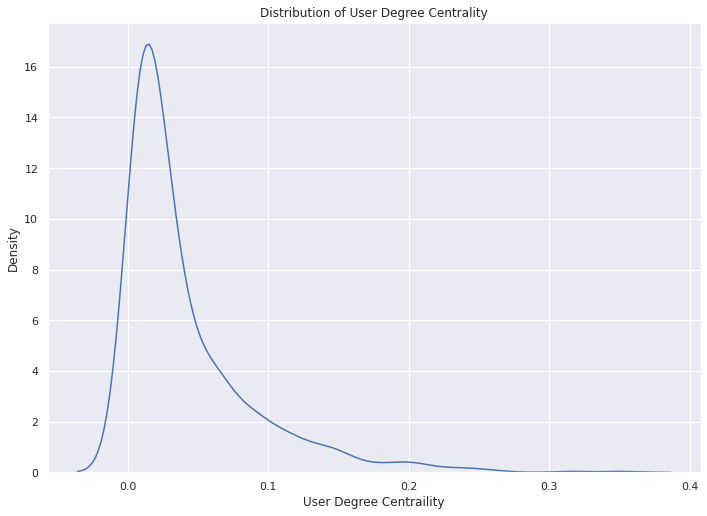

In [153]:
import seaborn as sns
import numpy as np
npvals = np.fromiter(sdcu.values(), dtype=float)
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.distplot(npvals, hist = False)
plt.title("Distribution of User Degree Centrality")
plt.xlabel("User Degree Centraility")


## How does this importance measure vary over the movie community?

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Movie Degree Centraility')

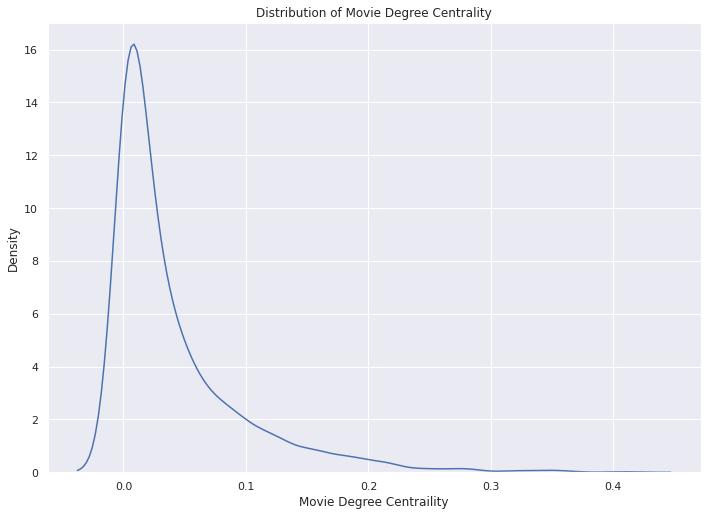

In [154]:
import seaborn as sns
import numpy as np
npvals = np.fromiter(sdcm.values(), dtype=float)
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.distplot(npvals, hist = False)
plt.title("Distribution of Movie Degree Centrality")
plt.xlabel("Movie Degree Centraility")


### Identified fact:
_We have a measure to capture the importance of a movie and a user on the basis of the rating activity performed on them. We have identified important users and movies in the network on the basis of this measure. We have also have information about how this importance measure varies over the users and movies in the data._

In [155]:
m4v = [t[0] for t in g.in_edges('Movies/4')]

## Similarity of nodes
Just like measures exist to quantify the importance of nodes in a network, there exist measures to quantify the similarity of nodes in a network. We will pick a random node in the network and characterize the similarity of nodes connected to it.

## How similar are viewers of the movie 'Get Shorty'?
In this example, we will use the __Jaccard__ similarity as a measure of node similarity. We first get all pairs of users who have seen the movie and then compute the __Jaccard__ similarity between them. The details are shown below. Networkx provides an API for this purpose that we will use.

In [156]:
from itertools import combinations
m4vucmb = list(combinations(m4v, 2))

In [157]:
import networkx as nx
gp = g.to_undirected()
jcp = nx.jaccard_coefficient(gp, m4vucmb)

In [158]:
jcpv = []
for u, v, p in jcp:
    jcpv.append(p)
    #print('(%s, %s) -> %.8f' % (u, v, p))

## What does the distribution of User Similarity look like?

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Jaccard Similarity')

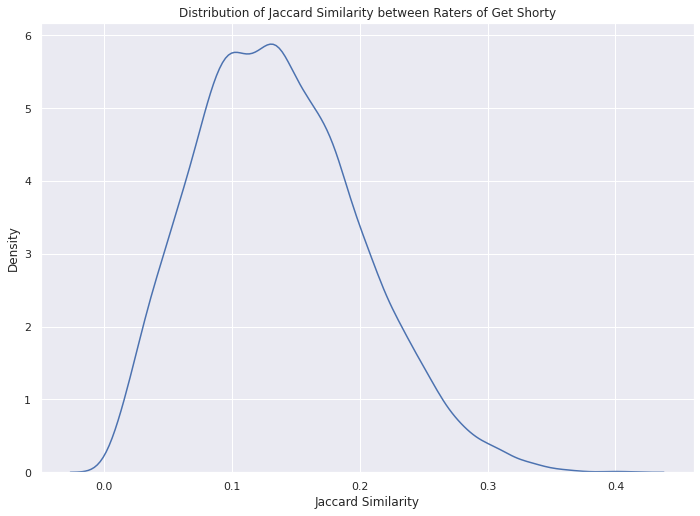

In [159]:
import seaborn as sns
import numpy as np
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.distplot(jcpv, hist = False)
plt.title("Distribution of Jaccard Similarity between Raters of Get Shorty")
plt.xlabel("Jaccard Similarity")

### Identified fact:
_Picking a random node in the graph, we characterized the similarity of nodes connected to it. In this dataset, we can use this idea to get a sense of how similar user's rating a movie tend to be. A review of the above figure shows that a range of similarities are observed._

## Bipartite Clustering
The next idea that we will investigate on the graph comes from [Latapy et.al](https://arxiv.org/abs/cond-mat/0611631). In this work, the authors extend the notion of clustering coefficients associated with a node to the case of bi-partite graphs. Since our graph is a bipartite graph, we will use this metric. See section VIII of the paper for a detailed explanation of the idea. Briefly, the clustering coefficient for a pair of nodes $u, v$, is defined as follows:
$$
\begin{equation*}
cc(u,v) = \frac{N(u)\cap N(v)}{N(u) \cup N(v)},
\end{equation*}
$$
where:

* N(u) is the neighborhood of node $u$. These are the nodes connected to $u$. For example, the movies user $u$ rates.
* N(v) is the neighborhood of node $v$.
Reviewing the above equation, it is evident that the clustering coefficient captures the shared neighborhood for a pair of nodes. Nodes associated with high clustering coefficient have many common neighbors. In the context of this problem, a pair of users with a high clustering coefficient suggests that these users have rated many movies in common. Similarly, a pair of movies with a high clustering coefficient suggests that these movies there are many common raters(users) for these movies. Networkx provides an implementation of this idea. The details of computing the clustering coefficients for the users and movies are shown below.
To obtain the clustering coefficient for a node $u$, we simply average the clustering coefficient of $u$ with other nodes that it shares common neighbors with. It is defined as follows:

$$
\begin{equation*}
cc(u) = \frac{\sum_{v \in N(u)} cc(u,v)}{\left| N(N(u) \right|},
\end{equation*}
$$


In [160]:
cr = bipartite.clustering(B)
cu = {}
cm = {}
for k, v in sorted(cr.items(),reverse=True, key=lambda item: item[1]):
    if k.startswith("Users"):
        cu[k] = v
    else:
        cm[k] = v

del cr

## List the top 10 users in terms of clustering tendencies 
These users share a high degree of common movie rating activity with other users. If rating is used as a proxy for the act of liking or disliking a movie, then user's with high clustering values share rating activity with 

In [161]:
list(cu.keys())[:10]

['Users/72',
 'Users/297',
 'Users/64',
 'Users/178',
 'Users/533',
 'Users/493',
 'Users/347',
 'Users/301',
 'Users/198',
 'Users/249']

## List the top 10 movies in terms of clustering tendencies 
These movies have a high degree of common users rating them.

In [162]:
list(cm.keys())[:10]

['Movies/1663',
 'Movies/1643',
 'Movies/1669',
 'Movies/1652',
 'Movies/1373',
 'Movies/1364',
 'Movies/1363',
 'Movies/1354',
 'Movies/1349',
 'Movies/1348']

## How does user clustering tendency vary over the community?

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'User Clustering Coefficients')

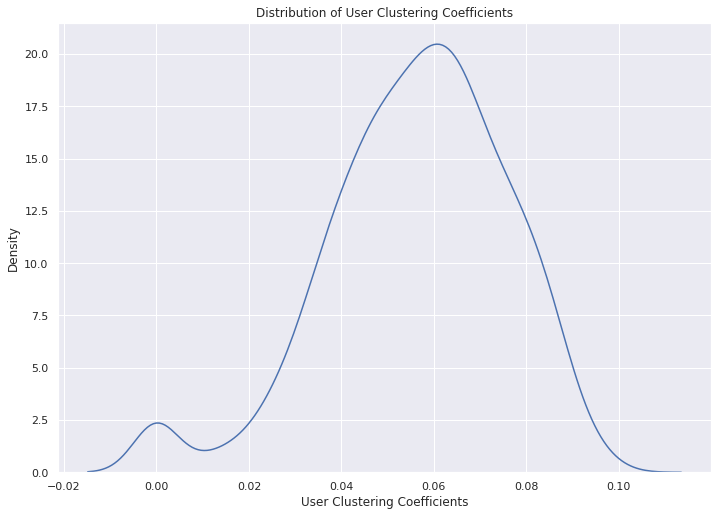

In [163]:
import seaborn as sns
import numpy as np
npvals = np.fromiter(cu.values(), dtype=float)
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.distplot(npvals, hist = False)
plt.title("Distribution of User Clustering Coefficients")
plt.xlabel("User Clustering Coefficients")


### Note:
Note that the distribution of user clustering coefficients has two humps (bi-modal). This suggests that there are two user communities. This is borne out when we visualize a sample of the user community using a _tSNE_ plot later in this notebook.

## How does movie clustering tendency vary over the community?

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Movie Clustering Coefficients')

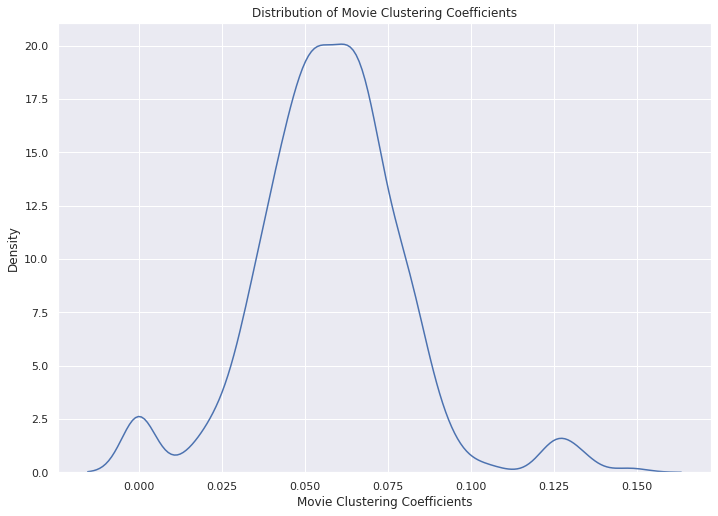

In [164]:
import seaborn as sns
import numpy as np
npvals = np.fromiter(cm.values(), dtype=float)
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.distplot(npvals, hist = False)
plt.title("Distribution of Movie Clustering Coefficients")
plt.xlabel("Movie Clustering Coefficients")

### Note:
Note that the distribution of user clustering coefficients has three humps. This suggests that there are three movie clusters. 


### Identified fact:
_We have identified users and movies that tend to have have a lot of common rating activity. We have identified that users and movies have clustering tendencies._

# Using Node2vec to obtain a graph embedding

Machine learning techniques can be applied on graphs to determine vector representations of graph elements such as nodes and edges. Such a representation is called an _embedding_. We can use the Networkx representation of the graph associated with the 10 most clustered users and determine its embedding. We can use a technique called [_t Stochastic Neighbor Embedding_](https://www.youtube.com/watch?v=RJVL80Gg3lA&list=UUtXKDgv1AVoG88PLl8nGXmw) to plot a two dimensional representation of this subgraph. The details of doing this is provided below. Earlier we noted that the user clustering tendencies were bi-modal. A review of the embedding of the sub-graph associated with the 10 most clustered users shows that there are two clusters in the data.

## Extract the sub-graph associated with the 10 most clustered users

In [165]:
t10cu = list(cu.keys())[:10]
proj_user = nx.bipartite.projected_graph(B, t10cu)

In [166]:
len(list(proj_user.edges()))

8796

In [167]:
len(proj_user.nodes())

914

## Embed the sub-graph using Node2vec 

In [168]:
from node2vec import Node2Vec
node2vec = Node2Vec(proj_user, dimensions=64, walk_length=10, num_walks=100, workers=4)

In [169]:
model = node2vec.fit(window=10, min_count=1, batch_words=4)

In [170]:
t10cu[2]

'Users/64'

## Apply the model
We can ask questions like "Who is most similar to (a particular user) Users/64?"

In [171]:
model.wv.most_similar(t10cu[2])

[('Users/249', 0.8666249513626099),
 ('Users/178', 0.8422333598136902),
 ('Users/493', 0.832413911819458),
 ('Users/347', 0.8107874393463135),
 ('Users/301', 0.8077564835548401),
 ('Users/297', 0.7933509349822998),
 ('Users/533', 0.7722172737121582),
 ('Users/896', 0.7490148544311523),
 ('Users/598', 0.7475563287734985),
 ('Users/483', 0.734812319278717)]

## Embed the graph with tSNE

In [172]:
t10cu_emb = { n: list(model.wv.get_vector(n)) for n in proj_user.nodes()}

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


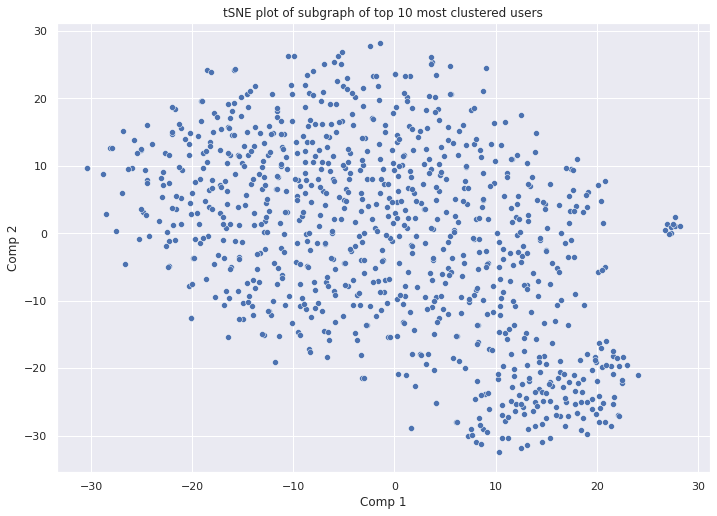

In [173]:
import numpy as np
from matplotlib  import cm
from sklearn.manifold import TSNE
fig = plt.figure(figsize=(11.7,8.27))
plt.grid(True)
plt.xlabel("Comp 1")
plt.ylabel("Comp 2")
plt.title("tSNE plot of subgraph of top 10 most clustered users")
t10cu_embedded = TSNE(n_components=2).fit_transform(list(t10cu_emb.values()))
sns.scatterplot(t10cu_embedded[:,0], t10cu_embedded[:,1])

__Using the Networkx adapter we have been able to perform a range of analysis tasks using the Networkx API. We were also able use the Networkx graph to obtain an embedding of a graph using Node2vec.__

## Store Embeddings in ArangoDB

In [174]:
%time
collection = db["Users"]
with BulkOperation(collection, batchSize=500) as col:
    #user_col = db.collections["Users"]
    for u, e in t10cu_emb.items():
        the_key = u.split('/')[1]
        the_user = collection[the_key]
        the_user["n2v_emb"] = e
        the_user.patch()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.11 µs


# Store metadata about these experiments using Arangopipe

In [ ]:
from arangopipe.arangopipe_storage.arangopipe_api import ArangoPipe
from arangopipe.arangopipe_storage.arangopipe_admin_api import ArangoPipeAdmin
from arangopipe.arangopipe_storage.arangopipe_config import ArangoPipeConfig
from arangopipe.arangopipe_storage.managed_service_conn_parameters import ManagedServiceConnParam
mdb_config = ArangoPipeConfig()
msc = ManagedServiceConnParam()
conn_params = { msc.DB_SERVICE_HOST : "arangoml.arangodb.cloud", \
                        msc.DB_SERVICE_END_POINT : "createDB",\
                        msc.DB_SERVICE_NAME : "createDB",\
                        msc.DB_SERVICE_PORT : 8529,\
                        msc.DB_CONN_PROTOCOL : 'https'}
        
mdb_config = mdb_config.create_connection_config(conn_params)
admin = ArangoPipeAdmin(reuse_connection = False, config = mdb_config)
ap_config = admin.get_config()
ap = ArangoPipe(config = ap_config)
proj_info = {"name": "IMDB_Movie_Reviews"}
proj_reg = admin.register_project(proj_info)

In [183]:
mdb_config.get_cfg()

{'arangodb': {'DB_end_point': 'createDB',
  'DB_service_host': 'arangoml.arangodb.cloud',
  'DB_service_name': 'createDB',
  'DB_service_port': 8529,
  'arangodb_replication_factor': None,
  'conn_protocol': 'https',
  'dbName': 'MLfihnc2v7dndo1zt7hvs27p',
  'password': 'MLi4rxshzlq3c00nwx63k60jaq',
  'username': 'MLu8bpng85889qv3msheqikc'},
 'mlgraph': {'graphname': 'enterprise_ml_graph'}}

In [178]:
import io
import requests
url = ('https://raw.githubusercontent.com/arangoml/networkx-adapter/master/examples/IMDB_Networkx_Adapter.ipynb')
nbjson = requests.get(url).text
model_info = {"name": "Exploratory Data Analysis IMDB",  "task": "multiple", 'notebook': nbjson}
model_reg = ap.register_model(model_info, project = "IMDB_Movie_Reviews")

# Summary

* The Networkx-Adapter makes it easy to obtain Networkx graphs from ArangoDB graphs.
* We have demonstrated that using a graph representation helped us identify facts about the data. These facts were identified by leveraging standard ideas from Network Theory.
* We have leveraged the Networkx graph to obtain a _Node2vec_ embedding of the graph associated with our data. For an example of how the Networkx-Adapter can be used with a _deep learning_ library, please view the [ITSM ArangoDB Adapter](https://github.com/arangoml/networkx-adapter/blob/master/examples/ITSM_ArangoDB_Adapter.ipynb).    